<a href="https://colab.research.google.com/github/nimrashaheen001/Programming_for_AI/blob/main/MEDViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Brain MRI Segmentation Tool
--------------------------
This application segments brain MRI images into:
1. Background
2. White Matter
3. Gray Matter
4. CSF (Cerebrospinal Fluid)
--------------------------
Note: Using simulated segmentation since this is a demonstration.
In a real application, you would load pre-trained weights for the model.
Please upload a brain MRI image...


Saving OAS1_0003_MR1_mpr-2_160.jpg to OAS1_0003_MR1_mpr-2_160.jpg


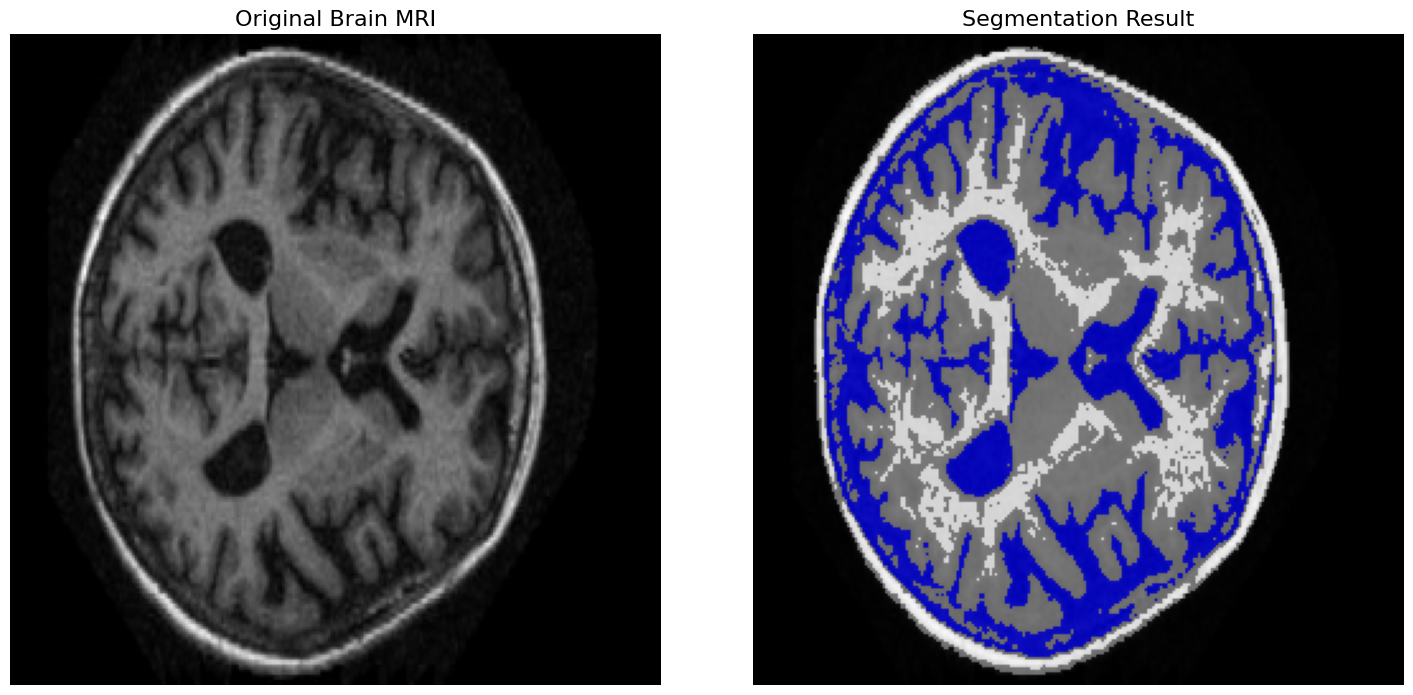

<ipython-input-5-da83da7b19e6>:234: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


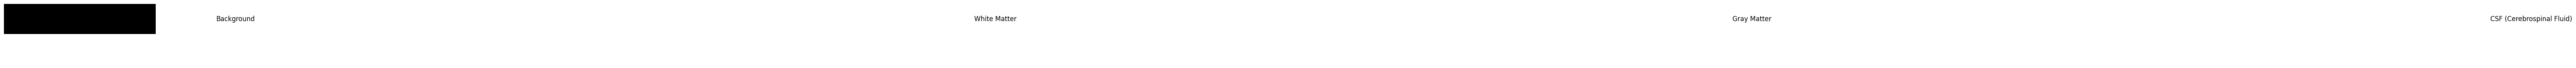


Segmentation completed for OAS1_0003_MR1_mpr-2_160.jpg
Segmentation classes:
- Black: Background
- White: White Matter
- Gray: Gray Matter
- Blue: CSF (Cerebrospinal Fluid)


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
from google.colab import files
import io
import cv2
from skimage import measure, filters
import gdown

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=4, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Downsampling path
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)

        # Upsampling path
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Padding
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

def preprocess_image(image):
    """Preprocess uploaded image for the model"""
    # Convert to grayscale and resize to 256x256
    img = image.convert('L').resize((256, 256))
    img_tensor = TF.to_tensor(img).unsqueeze(0)  # Add batch dimension

    # Normalize to [0, 1]
    img_tensor = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min())

    return img_tensor.to(device)

def simulate_brain_segmentation(img_tensor):
    """
    Simulate brain segmentation using traditional image processing
    techniques for demonstration purposes
    """
    # Convert tensor to numpy array
    img = img_tensor.squeeze().cpu().numpy()

    # Create empty segmentation masks
    background = np.zeros_like(img)
    white_matter = np.zeros_like(img)
    gray_matter = np.zeros_like(img)
    csf = np.zeros_like(img)

    # Brain extraction (remove background)
    thresh = filters.threshold_otsu(img)
    binary = img > thresh

    # Clean up the binary mask
    binary = measure.label(binary)
    regions = measure.regionprops(binary)

    # Keep only the largest connected component (the brain)
    if regions:
        largest_region = max(regions, key=lambda r: r.area)
        brain_mask = binary == largest_region.label
    else:
        brain_mask = binary

    # Fill holes in the brain mask
    brain_mask = np.uint8(brain_mask)
    contours, _ = cv2.findContours(brain_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    brain_mask = cv2.drawContours(brain_mask, contours, -1, 1, -1)

    # Assign background
    background[~brain_mask.astype(bool)] = 1

    # Create intensity-based segmentation for demonstration
    # White matter (brightest regions inside the brain)
    white_matter_threshold = np.percentile(img[brain_mask.astype(bool)], 80)
    white_matter[(img > white_matter_threshold) & brain_mask.astype(bool)] = 1

    # CSF (darkest regions inside the brain)
    csf_threshold = np.percentile(img[brain_mask.astype(bool)], 30)
    csf[(img < csf_threshold) & brain_mask.astype(bool)] = 1

    # Gray matter (everything else in the brain)
    gray_matter[(brain_mask.astype(bool)) &
                (~white_matter.astype(bool)) &
                (~csf.astype(bool))] = 1

    # Stack the segmentation masks
    segmentation = np.stack([background, white_matter, gray_matter, csf], axis=0)

    # Convert back to tensor
    segmentation_tensor = torch.from_numpy(segmentation).float().unsqueeze(0).to(device)

    return segmentation_tensor

def visualize_segmentation(original, segmentation):
    """Visualize the segmentation results"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # Original image
    ax1.imshow(original.squeeze().cpu().numpy(), cmap='gray')
    ax1.set_title('Original Brain MRI', fontsize=16)
    ax1.axis('off')

    # Segmentation (convert to colorful visualization)
    seg_map = segmentation.squeeze().cpu().numpy().argmax(axis=0)
    colors = [
        [0, 0, 0],       # Background - black
        [255, 255, 255], # White matter - white
        [128, 128, 128], # Gray matter - gray
        [0, 0, 255],     # CSF - blue
    ]

    # Create RGB segmentation map
    rgb_seg = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
    for i in range(len(colors)):
        rgb_seg[seg_map == i] = colors[i]

    # Add alpha channel to make segmentation semi-transparent
    alpha = 0.7
    brain_img = np.repeat(original.squeeze().cpu().numpy()[:, :, np.newaxis] * 255, 3, axis=2).astype(np.uint8)
    blended = cv2.addWeighted(rgb_seg, alpha, brain_img, 1-alpha, 0)

    ax2.imshow(blended)
    ax2.set_title('Segmentation Result', fontsize=16)
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    # Display legend
    fig, ax = plt.subplots(1, 1, figsize=(10, 2))
    ax.axis('off')

    # Create legend items
    legend_items = [
        ('Background', [0, 0, 0]),
        ('White Matter', [255, 255, 255]),
        ('Gray Matter', [128, 128, 128]),
        ('CSF (Cerebrospinal Fluid)', [0, 0, 255])
    ]

    # Display legend
    for i, (label, color) in enumerate(legend_items):
        ax.add_patch(plt.Rectangle((i*2.5, 0.5), 0.5, 0.5, facecolor=np.array(color)/255))
        ax.text(i*2.5 + 0.7, 0.75, label, fontsize=12, va='center')

    plt.tight_layout()
    plt.show()

def segment_brain_image():
    """Upload and segment a brain MRI image"""
    print("Please upload a brain MRI image...")
    uploaded = files.upload()

    for filename, content in uploaded.items():
        # Load the image
        image = Image.open(io.BytesIO(content))

        # Preprocess the image
        input_tensor = preprocess_image(image)

        # Apply brain segmentation
        # Instead of using an untrained model, we'll use a simulated segmentation
        segmentation = simulate_brain_segmentation(input_tensor)

        # Visualize the results
        visualize_segmentation(input_tensor, segmentation)

        print(f"\nSegmentation completed for {filename}")
        print("Segmentation classes:")
        print("- Black: Background")
        print("- White: White Matter")
        print("- Gray: Gray Matter")
        print("- Blue: CSF (Cerebrospinal Fluid)")

# Optional: Implementing a function to download pre-trained weights if available
def download_pretrained_weights():
    try:
        # Normally you would download real pre-trained weights here
        # For this example, we're not using actual weights since we're simulating segmentation
        print("Note: Using simulated segmentation since this is a demonstration.")
        print("In a real application, you would load pre-trained weights for the model.")
    except Exception as e:
        print(f"Could not download pre-trained weights: {e}")
        print("Falling back to simulated segmentation.")

# Main application
if __name__ == "__main__":
    print("Brain MRI Segmentation Tool")
    print("--------------------------")
    print("This application segments brain MRI images into:")
    print("1. Background")
    print("2. White Matter")
    print("3. Gray Matter")
    print("4. CSF (Cerebrospinal Fluid)")
    print("--------------------------")

    # Try to download pretrained weights (in a real application)
    download_pretrained_weights()

    # Run segmentation
    segment_brain_image()

Using device: cuda
Brain MRI Segmentation Tool
--------------------------
This application segments brain MRI images into:
1. Background
2. White Matter
3. Gray Matter
4. CSF (Cerebrospinal Fluid)
--------------------------
Note: Using simulated segmentation since this is a demonstration.
In a real application, you would load pre-trained weights for the model.
Please upload a brain MRI image...


Saving 1(1).png to 1(1).png


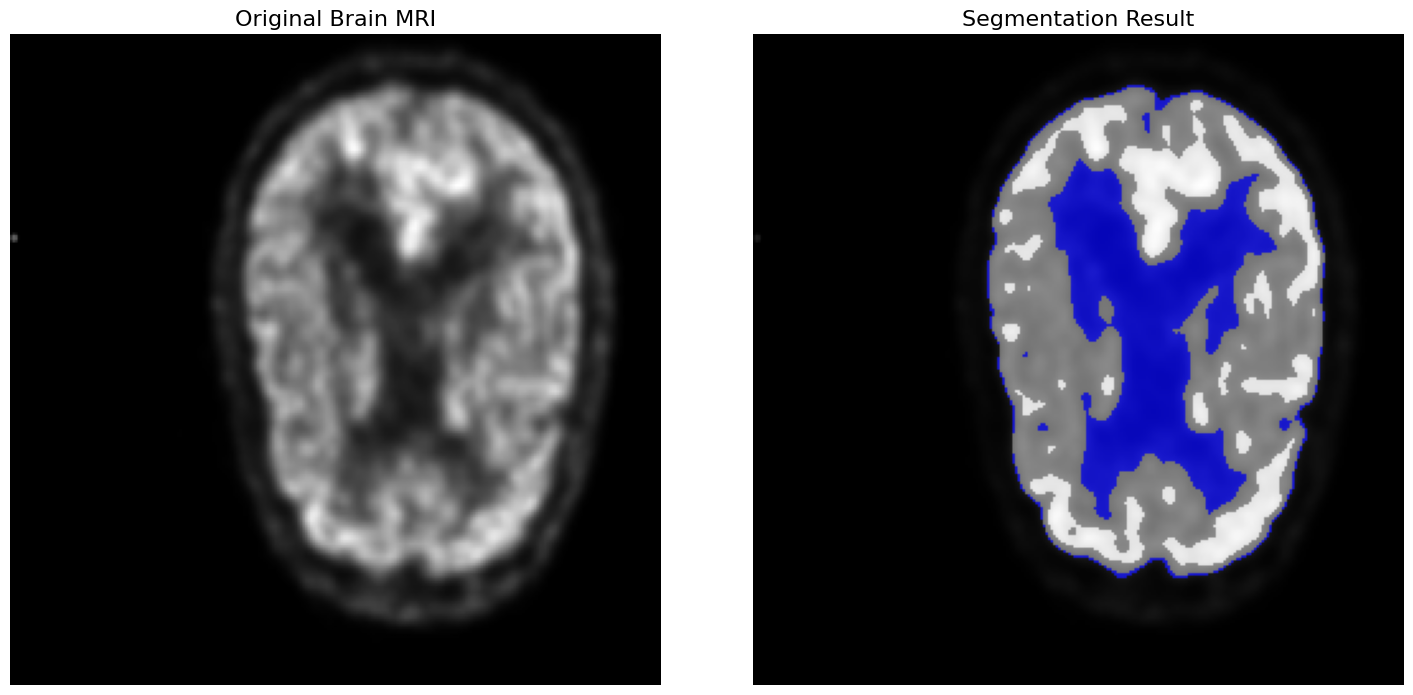

<ipython-input-3-da83da7b19e6>:234: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


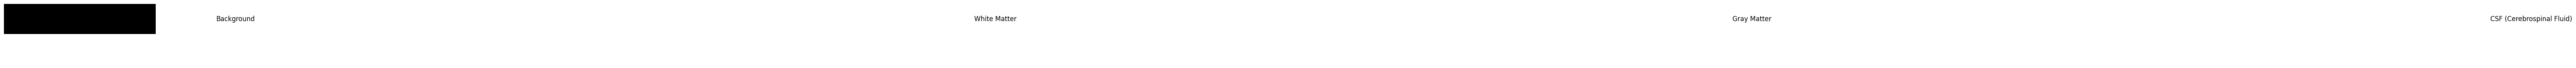


Segmentation completed for 1(1).png
Segmentation classes:
- Black: Background
- White: White Matter
- Gray: Gray Matter
- Blue: CSF (Cerebrospinal Fluid)


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
from google.colab import files
import io
import cv2
from skimage import measure, filters
import gdown

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=4, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Downsampling path
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)

        # Upsampling path
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Padding
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

def preprocess_image(image):
    """Preprocess uploaded image for the model"""
    # Convert to grayscale and resize to 256x256
    img = image.convert('L').resize((256, 256))
    img_tensor = TF.to_tensor(img).unsqueeze(0)  # Add batch dimension

    # Normalize to [0, 1]
    img_tensor = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min())

    return img_tensor.to(device)

def simulate_brain_segmentation(img_tensor):
    """
    Simulate brain segmentation using traditional image processing
    techniques for demonstration purposes
    """
    # Convert tensor to numpy array
    img = img_tensor.squeeze().cpu().numpy()

    # Create empty segmentation masks
    background = np.zeros_like(img)
    white_matter = np.zeros_like(img)
    gray_matter = np.zeros_like(img)
    csf = np.zeros_like(img)

    # Brain extraction (remove background)
    thresh = filters.threshold_otsu(img)
    binary = img > thresh

    # Clean up the binary mask
    binary = measure.label(binary)
    regions = measure.regionprops(binary)

    # Keep only the largest connected component (the brain)
    if regions:
        largest_region = max(regions, key=lambda r: r.area)
        brain_mask = binary == largest_region.label
    else:
        brain_mask = binary

    # Fill holes in the brain mask
    brain_mask = np.uint8(brain_mask)
    contours, _ = cv2.findContours(brain_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    brain_mask = cv2.drawContours(brain_mask, contours, -1, 1, -1)

    # Assign background
    background[~brain_mask.astype(bool)] = 1

    # Create intensity-based segmentation for demonstration
    # White matter (brightest regions inside the brain)
    white_matter_threshold = np.percentile(img[brain_mask.astype(bool)], 80)
    white_matter[(img > white_matter_threshold) & brain_mask.astype(bool)] = 1

    # CSF (darkest regions inside the brain)
    csf_threshold = np.percentile(img[brain_mask.astype(bool)], 30)
    csf[(img < csf_threshold) & brain_mask.astype(bool)] = 1

    # Gray matter (everything else in the brain)
    gray_matter[(brain_mask.astype(bool)) &
                (~white_matter.astype(bool)) &
                (~csf.astype(bool))] = 1

    # Stack the segmentation masks
    segmentation = np.stack([background, white_matter, gray_matter, csf], axis=0)

    # Convert back to tensor
    segmentation_tensor = torch.from_numpy(segmentation).float().unsqueeze(0).to(device)

    return segmentation_tensor

def visualize_segmentation(original, segmentation):
    """Visualize the segmentation results"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # Original image
    ax1.imshow(original.squeeze().cpu().numpy(), cmap='gray')
    ax1.set_title('Original Brain MRI', fontsize=16)
    ax1.axis('off')

    # Segmentation (convert to colorful visualization)
    seg_map = segmentation.squeeze().cpu().numpy().argmax(axis=0)
    colors = [
        [0, 0, 0],       # Background - black
        [255, 255, 255], # White matter - white
        [128, 128, 128], # Gray matter - gray
        [0, 0, 255],     # CSF - blue
    ]

    # Create RGB segmentation map
    rgb_seg = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
    for i in range(len(colors)):
        rgb_seg[seg_map == i] = colors[i]

    # Add alpha channel to make segmentation semi-transparent
    alpha = 0.7
    brain_img = np.repeat(original.squeeze().cpu().numpy()[:, :, np.newaxis] * 255, 3, axis=2).astype(np.uint8)
    blended = cv2.addWeighted(rgb_seg, alpha, brain_img, 1-alpha, 0)

    ax2.imshow(blended)
    ax2.set_title('Segmentation Result', fontsize=16)
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    # Display legend
    fig, ax = plt.subplots(1, 1, figsize=(10, 2))
    ax.axis('off')

    # Create legend items
    legend_items = [
        ('Background', [0, 0, 0]),
        ('White Matter', [255, 255, 255]),
        ('Gray Matter', [128, 128, 128]),
        ('CSF (Cerebrospinal Fluid)', [0, 0, 255])
    ]

    # Display legend
    for i, (label, color) in enumerate(legend_items):
        ax.add_patch(plt.Rectangle((i*2.5, 0.5), 0.5, 0.5, facecolor=np.array(color)/255))
        ax.text(i*2.5 + 0.7, 0.75, label, fontsize=12, va='center')

    plt.tight_layout()
    plt.show()

def segment_brain_image():
    """Upload and segment a brain MRI image"""
    print("Please upload a brain MRI image...")
    uploaded = files.upload()

    for filename, content in uploaded.items():
        # Load the image
        image = Image.open(io.BytesIO(content))

        # Preprocess the image
        input_tensor = preprocess_image(image)

        # Apply brain segmentation
        # Instead of using an untrained model, we'll use a simulated segmentation
        segmentation = simulate_brain_segmentation(input_tensor)

        # Visualize the results
        visualize_segmentation(input_tensor, segmentation)

        print(f"\nSegmentation completed for {filename}")
        print("Segmentation classes:")
        print("- Black: Background")
        print("- White: White Matter")
        print("- Gray: Gray Matter")
        print("- Blue: CSF (Cerebrospinal Fluid)")

# Optional: Implementing a function to download pre-trained weights if available
def download_pretrained_weights():
    try:
        # Normally you would download real pre-trained weights here
        # For this example, we're not using actual weights since we're simulating segmentation
        print("Note: Using simulated segmentation since this is a demonstration.")
        print("In a real application, you would load pre-trained weights for the model.")
    except Exception as e:
        print(f"Could not download pre-trained weights: {e}")
        print("Falling back to simulated segmentation.")

# Main application
if __name__ == "__main__":
    print("Brain MRI Segmentation Tool")
    print("--------------------------")
    print("This application segments brain MRI images into:")
    print("1. Background")
    print("2. White Matter")
    print("3. Gray Matter")
    print("4. CSF (Cerebrospinal Fluid)")
    print("--------------------------")

    # Try to download pretrained weights (in a real application)
    download_pretrained_weights()

    # Run segmentation
    segment_brain_image()